# Trabalho Prático 2 - Introduçao à Computação Visual

Aluno: Lucas Resende Pellegrinelli Machado

Matrícula: 2018126673

In [1]:
from logging import currentframe
import pygame
import cv2
import numpy as np
import imutils
import matplotlib.pyplot as plt
import time

import cv2
from OpenGL.GLU import *
from OpenGL import *
from OpenGL.GLUT import *
from PIL import Image
from objloader import *

pygame 2.0.1 (SDL 2.0.14, Python 3.8.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Definição do que será renderizado

Na célula abaixo serão definidos os objetos que serão renderizados. ```render_pikachu``` define se o pikachu será renderizado na cena e ```render_cubes``` define se os cubos serão renderizados.

In [2]:
render_pikachu = True
render_cubes = False

## Definição dos parâmetros da calibração obtidos

Os valores de calibraçao foram obtidos por meio do software http://www.vision.caltech.edu/bouguetj/calib_doc/.

As imagens utilizadas para a calibração são as seguintes

<table>
    <tr>
        <td><img src="https://i.imgur.com/N8Zk45F.jpg"></td>
        <td><img src="https://i.imgur.com/sUoeXgj.jpg"></td>
        <td><img src="https://i.imgur.com/D0feFNG.jpg"></td>
        <td><img src="https://i.imgur.com/AIilwQK.jpg"></td>
        <td><img src="https://i.imgur.com/K4kwMkd.jpg"></td>
    </tr>
</table>

Os resultados da calibração são os encontrados a seguir

<img src="https://i.imgur.com/LWCUdgH.png">

In [3]:
calibration_data = {
    'mtx': np.array([[416.7318, 0, 320.4061], [0, 414.1006, 221.29132], [0, 0, 1]]),
    'dist': np.array([0.08204, -0.01069, -0.00724, -0.01080, 0.00000])
}

## Identificação dos frames do vídeo

Nessa célula abriremos o arquivo de vídeo e faremos sua decomposição em cada um de seus frames, armazenando em um vetor ```all_frames```.

In [4]:
video = cv2.VideoCapture('entrada.mp4')
all_frames = []
while True:
    (ret, frame) = video.read()
    if ret: all_frames.append(frame)
    else: break

## Definição das funções dadas

Essa é a função dada pelos slides para ajustar a perspectiva da câmera do OpenGL para usar os parâmetros intrínsicos obtidos pela calibração.

In [5]:
def ajuste_intrinsecos_camera(width, height, K):
    fx = K[0, 0]
    fy = K[1, 1]
    fovy = 2 * np.arctan(0.5 * height / fy) * 180 / np.pi
    aspect = width * fy / (height * fx)
    gluPerspective(fovy, aspect, 0.1, 100.0)

## Definição de funções para a identificação dos alvos na imagem

- **```get_aruco_from_images(edged_image)```**: Função responsável por encontrar possíveis alvos na imagem utilizando apenas informações do contorno do imagem. Como parâmetro temos a imagem do frame que cujas bordas já foram encontradas (por meio da função ```cv2.Canny``` por exemplo). Como saída demos os contornos aproximados de possíveis alvos. A função funciona calculando um polígono aproximado para o contorno de cada borda e, caso esse polígono seja um quadrilátero e que a razão de área por perímetro for maior que um threshold, consideramos como um potencial alvo.


- **```image_similarity(img_a, img_b)```**: Calcula uma métrica de o quão parecidas duas imagens **binárizadas** são utilizando o mean squared error.


- **```unwarp_object(input_img, corner_pos, dimension=304)```**: Essa funçao, a partir da posição dos cantos de um objeto (```corner_pos```) e da imagem de onde esses cantos foram obtidos (```input_img```), descobre a homografia daquele objeto na imagem (por meio da função ```findHomography```) e retorna uma versão planificada do mesmo de dimensões ```dimension``` x ```dimension``` por meio da função ```warpPerspective()```.


- **```get_aruco_orientation(aruco_img, original_img)```**: Função responsável por descobrir qual a orientaçao de um alvo. Ela faz isso comparando a imagem planificada obtida por meio de ```unwarp_object()``` com cada uma das 4 rotações de 90 graus da imagem alvo original (e suas versões espelhadas) e escolhendo aquela que gerou o menor erro indicado por ```image_similarity()```.


- **```contour_aruco_similarity(gray_frame, contour, original_aruco)```**: Essa função é um wrapper das outras e serve para, a partir de um contorno, descobrir a posição dos cantos desse contorno, gerar a imagem planificada do objeto definido por aquele contorno e descobrir qual a orientação do mesmo. Essa função retorna uma 5-upla representando:
    1. Índice da orientação
    2. O quão diferente do aruco original a imagem é
    3. O vetor com a posição dos cantos da imagem
    4. A imagem do alvo planificado
    5. A imagem do alvo original rotacionado para "encaixar" com o alvo da imagem

In [6]:
def get_aruco_from_images(edged_image):
    # Encontra os contornos da imagem
    cnts = cv2.findContours(edged_image.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    
    # Aproxima os contornos para um polígono
    cnts = [cv2.approxPolyDP(c, 0.03 * cv2.arcLength(c, True), True) for c in cnts]
    
    # Ordena os contornos encontrados em ordem de maior para menor área
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[2::2]
    
    # Retira aqueles com número de arestas diferente de 4 e que razão de área e perímetro seja muito pequena
    cnts = [c for c in cnts if len(c) == 4 and cv2.contourArea(c) / cv2.arcLength(c, True) > 8]
    return cnts

def image_similarity(img_a, img_b):
    # Mean squared error com a diferença de imagens binárias
    return np.mean(np.square(img_a != img_b))

def unwarp_object(input_img, corner_pos, dimension=304):
    # Coordenadas alvo
    target = np.array([[0, 0], [0, dimension], [dimension, dimension], [dimension, 0]])
    
    # Homografia
    h, status = cv2.findHomography(corner_pos, target, cv2.RANSAC)
    
    # Distorção baseada na homografia
    unwarped_image = cv2.warpPerspective(input_img, h, (input_img.shape[1], input_img.shape[0]))
    unwarped_image = unwarped_image[:dimension, :dimension]
    
    # Binarização
    _, unwarped_image = cv2.threshold(unwarped_image, 127, 255, cv2.THRESH_BINARY)
    return unwarped_image
    
def get_aruco_orientation(aruco_img, original_img):
    # Define cada uma das possíveis rotações
    rotations = [None, cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180, cv2.ROTATE_90_CLOCKWISE]
    
    similarities = []
    for i in range(len(rotations)):
        # Rotaciona a imagem original baseado na rotação atual
        rotated_orig = original_img if rotations[i] is None else cv2.rotate(original_img, rotations[i])
        
        # Calcula a similaridade do alvo encontrado com a imagem rotacionada e invertida
        similarity_a = image_similarity(aruco_img, rotated_orig)
        similarity_b = image_similarity(aruco_img, rotated_orig[::-1])
        
        # Adiciona no vetor de resultados o melhor casamento encontrado para essa rotação
        if similarity_a <= similarity_b:
            similarities.append(((i + 2) % 4, similarity_a, rotated_orig, False))
        else:
            similarities.append((i, similarity_b, rotated_orig[::-1], True))

    # Retorna o melhor casamento dentre todas as rotações
    return min(similarities, key=lambda t: t[1])

def contour_aruco_similarity(gray_frame, contour, original_aruco):
    # Pega a imagem planificada do objeto na imagem
    unwarped_aruco = unwarp_object(gray_frame, np.squeeze(contour, 1))
    
    # Descobre a orientação e similaridade (com um alvo) do objeto
    orientation = get_aruco_orientation(unwarped_aruco, original_aruco)
    
    # Descobre as coordenadas dos cantos do objeto
    corner = np.squeeze(contour, 1) if not orientation[3] else np.squeeze(contour, 1)[::-1]
    return (orientation[0], orientation[1], corner, unwarped_aruco, orientation[2])

### Abrindo a imagem do alvo utilizado no vídeo

A célula abaixo abre e mostra qual a imagem do alvo utilizado no vídeo de entrada em sua rotação original

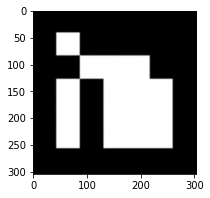

In [7]:
original_aruco = cv2.imread('alvo.jpg')
original_aruco = cv2.cvtColor(original_aruco, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(3, 3))
plt.imshow(original_aruco, cmap="gray")
plt.show()

## Exemplo do algoritmo implementado em um frame

Na célula abaixo temos um exemplo do algoritmo que será empregado no vídeo todo aplicado a apenas um frame. Isso nos dá a possibilidade de entender visualmente como o algoritmo a partir de uma imagem consegue identificar os alvos para então identificar sua pose.

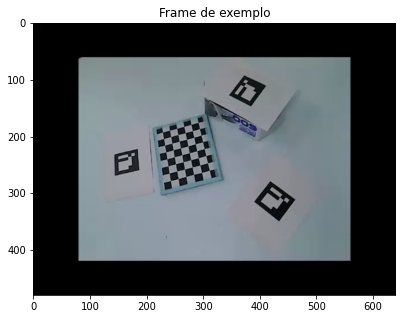

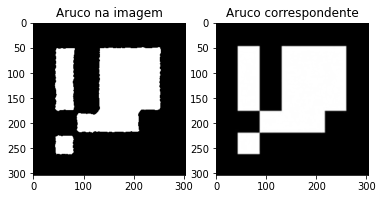

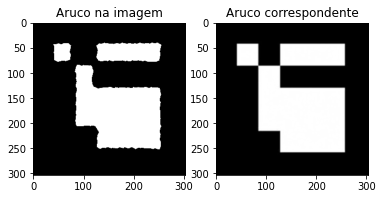

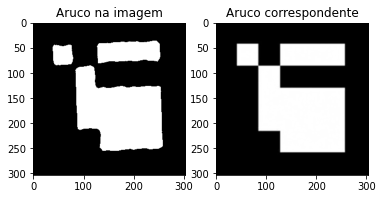

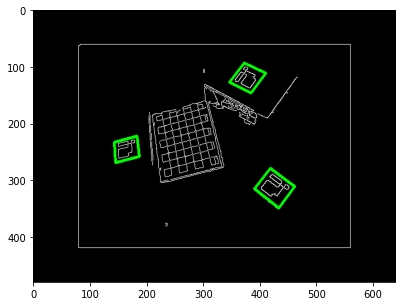

In [8]:
frame = all_frames[0]

plt.figure(figsize=(9, 5))
plt.title("Frame de exemplo")
plt.imshow(frame)
plt.show()

# Transforma a imagem em escala de cinza e tira as bordas
gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
frame_edges = cv2.Canny(gray_frame, 30, 200)

# Encontra o contornos de possíveis alvos na imagem
contours = get_aruco_from_images(frame_edges)

good_contours = []
for contour in contours:
    # Para cada contorno descubra a similaridade com um alvo, orientação e tudo mais
    orientation, similarity, corners, unwarped, target_aruco = contour_aruco_similarity(gray_frame, contour, original_aruco)
    
    # Caso a similaridade seja boa o suficiente e que a imagem não seja só preto ou só branco
    if similarity < 0.4 and (20 <= np.mean(unwarped) <= 200):
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.set_title("Aruco na imagem")
        ax1.imshow(unwarped, cmap="gray")
        ax2.set_title("Aruco correspondente")
        ax2.imshow(target_aruco, cmap="gray")
        plt.show()
        
        # Adiciona no vetor de contornos que serão considerados como alvos
        good_contours.append(contour)
        
plt.figure(figsize=(9, 5))
plt.imshow(cv2.drawContours(cv2.cvtColor(frame_edges, cv2.COLOR_GRAY2RGB), good_contours, -1, (0, 255, 0), 3))
plt.show()

## Aplicação do algoritmo em todos os frames do vídeo

Aqui vamos utilizar o algoritmo demonstrado na célula acima para encontrar os alvos e detectar a pose para cada um dos frames do vídeo. As informações obtidas são guardadas no dicionário ```frame_info``` que armazena todas as informações necessárias para o OpenGL poder posteriormente renderizar a cena como queremos.

In [9]:
frame_info = {}

for (frame_i, frame) in enumerate(all_frames):
    if frame_i % (len(all_frames) // 10) == 0:
        print("Processado", str(100 * frame_i / len(all_frames)) + "%", "dos frames")
    
    # Transforma a imagem em escala de cinza e tira as bordas
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame_edges = cv2.Canny(gray_frame, 30, 200)

    # Encontra o contornos de possíveis alvos na imagem
    contours = get_aruco_from_images(frame_edges)

    good_contours = []
    good_corners = []
    good_orientations = []
    for contour in contours:
        # Para cada contorno descubra a similaridade com um alvo, orientação e tudo mais
        orientation, similarity, corners, unwarped, _ = contour_aruco_similarity(gray_frame, contour, original_aruco)
        
        # Caso a similaridade seja boa o suficiente e que a imagem não seja só preto ou só branco
        if similarity < 0.4 and (20 <= np.mean(unwarped) <= 200):
            good_contours.append(contour)
            good_corners.append(corners)
            good_orientations.append(orientation)

    object_poses = []
    # Para cada objeto identificado como alvo
    for i, (corner, orientation) in enumerate(zip(good_corners, good_orientations)):
        # Descubra a coordenada arbitrátia correspondente a sua orientação
        object_points = np.array([[-1.0, -1.0, 0], [1.0, -1.0, 0], [1.0, 1.0, 0], [-1.0, 1.0, 0]])
        object_points = np.roll(object_points, orientation + 2, axis=0)
        
        # Descobre a pose
        _, rvecs, tvecs = cv2.solvePnP(object_points, corner.astype(float), calibration_data['mtx'], calibration_data['dist'])
        rodr, _ = cv2.Rodrigues(rvecs)
        
        # Cria a matriz modelview
        modelview_mat = np.append(rodr, tvecs, axis=1)
        modelview_mat = np.append(modelview_mat, [[0, 0, 0, 1]], axis=0)
        modelview_mat[1:3, 0:4] *= -1
        object_poses.append(np.transpose(modelview_mat))

    frame_info[frame_i] = {
        'frame': frame,
        'contoured-frame': cv2.drawContours(cv2.cvtColor(frame_edges, cv2.COLOR_GRAY2RGB), good_contours, -1, (0, 255, 0), 3),
        'modelview_mats': object_poses
    }

Processado 0.0% dos frames
Processado 10.0% dos frames
Processado 20.0% dos frames
Processado 30.0% dos frames
Processado 40.0% dos frames
Processado 50.0% dos frames
Processado 60.0% dos frames
Processado 70.0% dos frames
Processado 80.0% dos frames
Processado 90.0% dos frames


## Importando o modelo do Pikachu

In [10]:
pikachu_obj = None

def get_pikachu_obj():
    global pikachu_obj
    
    if pikachu_obj is None:
        pikachu_obj = OBJ('Pikachu.obj', swapyz=True)
    return pikachu_obj

## Definindo funções básicas do OpenGL

2. **```render_background()```** é a função responsável a plotar no ambiente 3D uma imagem que ocupe toda o campo de visão da camera.

In [11]:
def renderBackground(background_image, dimensions):
    w, h = dimensions
    x, y = (0, 0)

    glBindTexture(GL_TEXTURE_2D, glGenTextures(1))
    glTexParameteri(GL_TEXTURE_2D, GL_TEXTURE_MIN_FILTER, GL_NEAREST)
    glTexParameteri(GL_TEXTURE_2D, GL_TEXTURE_MAG_FILTER, GL_NEAREST)
    glTexImage2D(GL_TEXTURE_2D, 0, GL_RGB, w, h, 0, GL_BGR, GL_UNSIGNED_BYTE, background_image)

    glDepthMask(GL_FALSE)
    glMatrixMode(GL_PROJECTION)
    glLoadIdentity()
    glOrtho(0, w, h, 0.0, 0.0, 1)
    
    glEnable(GL_TEXTURE_2D)
    glBegin(GL_QUADS)
    
    for i, j in [(0, 0), (1, 0), (1, 1), (0, 1)]:
        glTexCoord2f(i, j)
        glVertex2f(x + w * i, y + h * j)

    glEnd()

    glBindTexture(GL_TEXTURE_2D, 0)
    glDepthMask(GL_TRUE)

## Função principal de criação da imagem para cada frame

Nessa célula podemos ver o código responsável por exibir na tela um dos frames do vídeo. Inicialmente renderizamos a imagem do frame original onde desejamos desenhar por cima utilizando a função criada anteriormente ```render_background()```. Posteriormente ajustamos a camera com os valores da calibração e então partimos para a renderização dos objetos 3D.

Para renderiza-los, no dicionário ```frame_info``` criado anteriormente foi armazenado o valor de pose para cada objeto em cada um dos frames, logo basta obter essa pose que já foi calculada anteriormente, aplicar à matriz ```modelview``` e então renderizar os objetos como se estivessem na origem. No caso do cubo, foi utilizada a função ```glutWireCube()``` e um vértice para identificar a direção do cubo e no caso do Pikachu foi utilizado a função ```glCallList()```.

Por fim, é utilizada a função ```time.sleep(1 / 30)``` para garantir que o vídeo seja executado em uma velocidade próxima a original.

In [12]:
current_frame = 0

def displayCallback():
    global current_frame
    global render_pikachu
    global render_cubes

    glMatrixMode(GL_MODELVIEW)
    glLoadIdentity()
    glClear(GL_COLOR_BUFFER_BIT | GL_DEPTH_BUFFER_BIT)

    # Renderiza o fundo com a imagem do vídeo
    renderBackground(frame_info[current_frame]['frame'], (640, 480))
    current_frame = (current_frame + 1) % len(frame_info)

    glMatrixMode(GL_PROJECTION)
    glLoadIdentity() 
    ajuste_intrinsecos_camera(640, 480, calibration_data['mtx'])

    glMatrixMode(GL_MODELVIEW)
    glLoadIdentity()
    glEnable(GL_TEXTURE_2D)

    # Para cada alvo identificado na imagem, coloque o objeto em questão em cima
    for mv_i in range(len(frame_info[current_frame]['modelview_mats'])):
        modelview_mat = frame_info[current_frame]['modelview_mats'][mv_i]
        glLoadMatrixf(modelview_mat)
        
        if render_cubes:
            # Cria um wire cube com um dos vértices coloridos
            glPushAttrib(GL_CURRENT_BIT)
            glColor3f(1.0, 0.0, 0.5)
            glLineWidth(4.0)
            glTranslate(0, 0, 1)
            glutWireCube(2.0)
            
            # Cria uma linha para representar o vértice colorido
            glLineWidth(6.0)
            glColor3f(0.0, 1.0, 0.0)
            glBegin(GL_LINES)
            glVertex3f(-1, 1, -0.9)
            glVertex3f(1, 1, -0.9)
            glEnd()
            
            glPopAttrib()
            
        if render_pikachu:
            # Cria o pikachu
            glCallList(get_pikachu_obj().gl_list)

    glutSwapBuffers()
    time.sleep(1 / 30)

## Chamada das funções para inicializar o OpenGL

Aqui é onde executamos todas as funções para que possamos inicializar a renderização. Criamos a janela, chaamamos ```init_open_gl()``` para inicializar o ambiente e a função ```glutDisplayFunc(display_callback)``` começa a chamar repetidamente nossa função que renderiza um frame que atualiza frame a frame a execução do vídeo.

In [13]:
dimensoesFrame = (640, 480)
glutInit()
glutInitDisplayMode(GLUT_RGBA | GLUT_DOUBLE)
glutSetOption(GLUT_ACTION_ON_WINDOW_CLOSE, GLUT_ACTION_CONTINUE_EXECUTION)
glutInitWindowSize(*dimensoesFrame)
glutCreateWindow(b'Realidade Aumentada - Pikachu')

glClearColor(0, 0, 0, 0)
glClearDepth(1.0)
glEnable(GL_DEPTH_TEST)
glMatrixMode(GL_PROJECTION)
glLoadIdentity()

ajuste_intrinsecos_camera(dimensoesFrame[0], dimensoesFrame[1], calibration_data['mtx'])

glutDisplayFunc(displayCallback)
glutIdleFunc(glutPostRedisplay)

glutMainLoop()

## Referências

1. https://stackoverflow.com/questions/56767373/how-to-blit-a-png-image-as-an-image-overlay-in-pyopengl
2. https://www.pyimagesearch.com/2014/04/21/building-pokedex-python-finding-game-boy-screen-step-4-6/
3. https://www.pyimagesearch.com/2014/05/05/building-pokedex-python-opencv-perspective-warping-step-5-6/
4. https://stackoverflow.com/questions/21104664/extract-all-bounding-boxes-using-opencv-python
5. https://www.geeksforgeeks.org/python-opencv-cv2-rotate-method/
6. https://learnopencv.com/augmented-reality-using-aruco-markers-in-opencv-c-python/
7. https://docs.opencv.org/
8. https://docs.opencv.org/master/d7/d53/tutorial_py_pose.html
9. https://medium.com/analytics-vidhya/using-homography-for-pose-estimation-in-opencv-a7215f260fdd
10. https://www.youtube.com/watch?v=j_EDFd9RkqE